# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "Median"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'Median',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_Median'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                                                                                                                                             
Sample_028  H0Y5E4;H0YCV9;H0YD13;H0YDW7;P16070;P16070-10;P16070-11;P16070-12;P16070-13;P16070-14;P16070-15;P16070-16;P16070-17;P16070-18;P16070-3;P16070-4;P16070-5;P16070-6;P16070-7;P16070-8;P16070-9   20.451
Sample_121  A0A0B4J1Z1;C9JAB2;Q16629;Q16629-2;Q16629-3;Q16629-4                                                                                                                                           15.840
Sample_051  P54289-2;P54289-3                                                                                                                                                                             18.872
Sample_125  D6RJG0;Q9Y6N8                                                                                                                                                    

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by Median: runs/alzheimer_study/preds/pred_real_na_Median.csv


Sample ID   protein groups 
Sample_197  P10644;P10644-2   14.059
Sample_158  P50395            16.807
Sample_108  P30048;P30048-2   14.672
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.054
            A0A075B6Q5                 13.060
            A0A075B6R2                 13.744
            A0A075B6S5                 12.530
            A0A087WSY4                 13.048
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.446
            Q9UI40;Q9UI40-2            12.765
            Q9UIW2                     12.556
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.668
            Q9UP79                     12.348
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.256,15.050,16.842,19.863,15.328,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.242,19.067,...,15.528,15.576,14.256,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.328,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,16.722,17.705,17.039,17.501,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,16.722,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.256,15.345,17.084,18.708,14.249,19.433,12.408,11.404
Sample_207,15.739,16.877,15.469,16.898,16.722,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.829,14.249,12.360,13.127,13.221,13.556,14.464,13.674,13.632,12.611
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.343,19.067,16.127,...,12.162,14.366,13.008,13.161,12.557,13.057,12.655,12.544,12.097,13.908
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.618,12.756,13.616,12.496,12.429,12.909,13.710,12.523,12.766,14.290
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,11.518,12.423,12.865,11.797,14.629,12.504,12.972,11.040,13.228,13.967
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.251,12.327,12.586,13.674,12.137,14.654,12.607,13.181,13.092,11.955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,10.996,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 400.41it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.98it/s]

100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.58it/s]

100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.30it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.74it/s]

100%|██████████| 4/4 [00:00<00:00,  4.41it/s]

100%|██████████| 4/4 [00:00<00:00,  4.74it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.07it/s]

 60%|██████    | 3/5 [00:00<00:00,  6.40it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.03it/s]

100%|██████████| 5/5 [00:01<00:00,  4.14it/s]

100%|██████████| 5/5 [00:01<00:00,  4.75it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.73it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.16it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.67it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.09it/s]

100%|██████████| 6/6 [00:01<00:00,  4.25it/s]

100%|██████████| 6/6 [00:01<00:00,  4.57it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.30it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.82it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.13it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.01it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.87it/s]

100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.19it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.38it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.36it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.17it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.13it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.99it/s]

100%|██████████| 8/8 [00:01<00:00,  3.83it/s]

100%|██████████| 8/8 [00:01<00:00,  4.23it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.56it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.31it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.59it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.30it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.87it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.88it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.74it/s]

100%|██████████| 9/9 [00:02<00:00,  3.78it/s]

100%|██████████| 9/9 [00:02<00:00,  4.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.78it/s]

 30%|███       | 3/10 [00:00<00:01,  4.23it/s]

 40%|████      | 4/10 [00:00<00:01,  4.28it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.27it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.24it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.12it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.79it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.55it/s]

100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.80it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.41it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.78it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.59it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.30it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.22it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.04it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.06it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.04it/s]

100%|██████████| 11/11 [00:02<00:00,  4.10it/s]

100%|██████████| 11/11 [00:02<00:00,  4.37it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.68it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.38it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.59it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.32it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.22it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.04it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.12it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.00it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.05it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.91it/s]

100%|██████████| 12/12 [00:02<00:00,  3.95it/s]

100%|██████████| 12/12 [00:02<00:00,  4.24it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.45it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.64it/s]

 31%|███       | 4/13 [00:01<00:02,  3.05it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.06it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.21it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.22it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.23it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.37it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.49it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.55it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.55it/s]

100%|██████████| 13/13 [00:03<00:00,  3.68it/s]

100%|██████████| 13/13 [00:03<00:00,  3.48it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.81it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.15it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.51it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.08it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.04it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.84it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.36it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.06it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  2.95it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.75it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.87it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.94it/s]

100%|██████████| 14/14 [00:04<00:00,  3.25it/s]

100%|██████████| 14/14 [00:04<00:00,  3.44it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.10it/s]

 20%|██        | 3/15 [00:00<00:02,  4.34it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.77it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.59it/s]

 40%|████      | 6/15 [00:01<00:02,  3.58it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.65it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.67it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.69it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.57it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.65it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.62it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.51it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.49it/s]

100%|██████████| 15/15 [00:04<00:00,  3.71it/s]

100%|██████████| 15/15 [00:04<00:00,  3.72it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.037 0.003          0.756 0.355       0.122   
2             0.003 0.000      0.037 0.000          0.619 0.137       0.468   
3             0.003 0.000      0.037 0.000          0.787 0.083       0.712   
4             0.003 0.000      0.036 0.001          0.807 0.084       0.776   
5             0.003 0.000      0.038 0.004          0.827 0.081       0.792   
6             0.003 0.000      0.038 0.006          0.829 0.082       0.799   
7             0.004 0.000      0.038 0.003          0.829 0.074       0.800   
8             0.004 0.003      0.038 0.008          0.834 0.083       0.798   
9             0.004 0.000      0.037 0.004          0.836 0.076       0.839   
10            0.003 0.001      0.033 0.005          0.840 0.079       0.837   
11            0.003 0.000      0.035 0.004          0.844 0.072       0.823   
12            0.004 0.003      0.041 0.014          0.839 0.075       0.820   
13            0.006 0.005      0.053 0.019          0.836 0.078       0.810   
14            0.004 0.001      0.039 0.009          0.834 0.080       0.809   
15            0.005 0.004      0.053 0.018          0.838 0.074       0.814   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.204 0.131                  0.554 0.042        0.851   
2          0.118   0.522 0.099                  0.622 0.067        0.702   
3          0.099   0.743 0.072                  0.784 0.058        0.894   
4          0.106   0.785 0.069                  0.818 0.058        0.906   
5          0.101   0.805 0.070                  0.834 0.058        0.914   
6          0.095   0.809 0.065                  0.837 0.055        0.913   
7          0.087   0.810 0.056                  0.838 0.046        0.911   
8          0.088   0.812 0.066                  0.840 0.055        0.915   
9          0.095   0.834 0.069                  0.859 0.059        0.926   
10         0.095   0.834 0.067                  0.859 0.058        0.924   
11         0.096   0.830 0.066                  0.856 0.056        0.929   
12         0.105   0.825 0.073                  0.852 0.060        0.928   
13         0.105   0.818 0.072                  0.846 0.059        0.927   
14         0.109   0.816 0.075                  0.844 0.061        0.925   
15         0.109   0.821 0.071                  0.849 0.058        0.926   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.824 0.089        210.000 0.000  
2          0.083                  0.653 0.098        210.000 0.000  
3          0.049                  0.873 0.058        210.000 0.000  
4          0.046                  0.884 0.055        210.000 0.000  
5          0.048                  0.896 0.058        210.000 0.000  
6          0.049                  0.895 0.057        210.000 0.000  
7          0.049                  0.894 0.056        210.000 0.000  
8          0.048                  0.902 0.054        210.000 0.000  
9          0.043                  0.916 0.046        210.000 0.000  
10         0.044                  0.912 0.050        210.000 0.000  
11         0.046                  0.918 0.050        210.000 0.000  
12         0.046                  0.917 0.050        210.000 0.000  
13         0.047                  0.916 0.050        210.000 0.000  
14         0.047                  0.914 0.050        210.000 0.000  
15         0.047                  0.912 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 501.95it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.80it/s]

100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.13it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.44it/s]

100%|██████████| 4/4 [00:00<00:00,  4.01it/s]

100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.27it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.24it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.87it/s]

100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.53it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.94it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.75it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.37it/s]

100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.43it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.92it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.18it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.35it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.30it/s]

100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.93it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.62it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.31it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.46it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.38it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.51it/s]

100%|██████████| 8/8 [00:02<00:00,  3.52it/s]

100%|██████████| 8/8 [00:02<00:00,  3.55it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.30it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.41it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.86it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.68it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.69it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.84it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.84it/s]

100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

100%|██████████| 9/9 [00:02<00:00,  3.02it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.00it/s]

 30%|███       | 3/10 [00:00<00:01,  3.88it/s]

 40%|████      | 4/10 [00:01<00:01,  3.11it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.82it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.74it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.95it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.05it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.16it/s]

100%|██████████| 10/10 [00:03<00:00,  3.23it/s]

100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.34it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.45it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.20it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.70it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.67it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.57it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.76it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.88it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.03it/s]

100%|██████████| 11/11 [00:03<00:00,  3.07it/s]

100%|██████████| 11/11 [00:03<00:00,  3.06it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.12it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.41it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.19it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.94it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.77it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.11it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.70it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.61it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.50it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.67it/s]

100%|██████████| 12/12 [00:03<00:00,  2.80it/s]

100%|██████████| 12/12 [00:03<00:00,  3.10it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.23it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.54it/s]

 31%|███       | 4/13 [00:01<00:02,  3.55it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.37it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.35it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.31it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.09it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.04it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.08it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.93it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.84it/s]

100%|██████████| 13/13 [00:04<00:00,  2.73it/s]

100%|██████████| 13/13 [00:04<00:00,  3.14it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.29it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.64it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.87it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.59it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.38it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.46it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.50it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.55it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.66it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.82it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  3.01it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.14it/s]

100%|██████████| 14/14 [00:04<00:00,  3.34it/s]

100%|██████████| 14/14 [00:04<00:00,  2.93it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.58it/s]

 20%|██        | 3/15 [00:00<00:02,  4.14it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.00it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.59it/s]

 40%|████      | 6/15 [00:01<00:02,  3.57it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.48it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.30it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.18it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.22it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.26it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.90it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.64it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.56it/s]

100%|██████████| 15/15 [00:04<00:00,  2.59it/s]

100%|██████████| 15/15 [00:04<00:00,  3.11it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.056 0.022          0.000 0.000       0.000   
2             0.006 0.006      0.061 0.027          0.751 0.123       0.440   
3             0.005 0.004      0.055 0.024          0.713 0.084       0.671   
4             0.004 0.002      0.044 0.016          0.705 0.087       0.671   
5             0.005 0.003      0.047 0.016          0.739 0.096       0.678   
6             0.005 0.004      0.051 0.019          0.747 0.106       0.695   
7             0.006 0.005      0.057 0.019          0.741 0.105       0.703   
8             0.005 0.004      0.052 0.022          0.788 0.095       0.766   
9             0.006 0.006      0.057 0.022          0.785 0.103       0.769   
10            0.006 0.005      0.058 0.026          0.773 0.100       0.752   
11            0.004 0.002      0.057 0.024          0.816 0.086       0.816   
12            0.004 0.000      0.041 0.011          0.816 0.087       0.820   
13            0.005 0.004      0.051 0.017          0.840 0.086       0.799   
14            0.006 0.005      0.053 0.023          0.840 0.089       0.801   
15            0.004 0.002      0.045 0.015          0.840 0.090       0.797   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.822   
2          0.110   0.545 0.100                  0.663 0.057        0.665   
3          0.115   0.687 0.089                  0.737 0.069        0.815   
4          0.116   0.684 0.093                  0.733 0.072        0.810   
5          0.130   0.702 0.102                  0.752 0.077        0.825   
6          0.116   0.714 0.092                  0.759 0.074        0.834   
7          0.124   0.716 0.093                  0.760 0.075        0.843   
8          0.118   0.770 0.079                  0.805 0.065        0.897   
9          0.123   0.770 0.086                  0.804 0.071        0.894   
10         0.125   0.755 0.087                  0.792 0.071        0.893   
11         0.108   0.812 0.078                  0.839 0.067        0.912   
12         0.102   0.814 0.074                  0.841 0.065        0.912   
13         0.104   0.815 0.075                  0.842 0.063        0.922   
14         0.103   0.816 0.078                  0.843 0.066        0.919   
15         0.107   0.813 0.079                  0.841 0.067        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.799 0.086        210.000 0.000  
2          0.072                  0.659 0.083        210.000 0.000  
3          0.068                  0.795 0.070        210.000 0.000  
4          0.070                  0.788 0.073        210.000 0.000  
5          0.069                  0.800 0.081        210.000 0.000  
6          0.067                  0.817 0.077        210.000 0.000  
7          0.062                  0.813 0.075        210.000 0.000  
8          0.048                  0.868 0.061        210.000 0.000  
9          0.050                  0.863 0.066        210.000 0.000  
10         0.052                  0.864 0.064        210.000 0.000  
11         0.047                  0.886 0.061        210.000 0.000  
12         0.047                  0.885 0.062        210.000 0.000  
13         0.043                  0.897 0.058        210.000 0.000  
14         0.047                  0.895 0.059        210.000 0.000  
15         0.049                  0.895 0.061 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1164.76it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 20.27it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 27.19it/s]

100%|██████████| 3/3 [00:00<00:00, 26.95it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 26.21it/s]

100%|██████████| 4/4 [00:00<00:00, 18.55it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.76it/s]

100%|██████████| 5/5 [00:00<00:00, 16.02it/s]

100%|██████████| 5/5 [00:00<00:00, 15.69it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.66it/s]

100%|██████████| 6/6 [00:00<00:00, 15.31it/s]

100%|██████████| 6/6 [00:00<00:00, 15.88it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 22.36it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 13.30it/s]

100%|██████████| 7/7 [00:00<00:00, 14.10it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.03it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 17.84it/s]

100%|██████████| 8/8 [00:00<00:00, 15.74it/s]

100%|██████████| 8/8 [00:00<00:00, 16.49it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.84it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 16.29it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 14.90it/s]

100%|██████████| 9/9 [00:00<00:00, 12.66it/s]

100%|██████████| 9/9 [00:00<00:00, 13.91it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.13it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.85it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.46it/s]

 90%|█████████ | 9/10 [00:00<00:00, 12.37it/s]

100%|██████████| 10/10 [00:00<00:00, 12.68it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 18.77it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.01it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.86it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.70it/s]

100%|██████████| 11/11 [00:00<00:00, 12.17it/s]

100%|██████████| 11/11 [00:00<00:00, 12.98it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.34it/s]

 50%|█████     | 6/12 [00:00<00:00, 15.65it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 15.77it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.47it/s]

100%|██████████| 12/12 [00:00<00:00, 14.45it/s]

100%|██████████| 12/12 [00:00<00:00, 15.20it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 17.25it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.97it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.74it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.68it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.44it/s]

100%|██████████| 13/13 [00:01<00:00, 11.97it/s]

100%|██████████| 13/13 [00:01<00:00, 12.74it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.52it/s]

 36%|███▌      | 5/14 [00:00<00:00, 16.89it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.22it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.51it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.24it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 12.66it/s]

100%|██████████| 14/14 [00:01<00:00, 13.45it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.92it/s]

 40%|████      | 6/15 [00:00<00:00, 13.60it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 12.75it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 12.34it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.55it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 13.87it/s]

100%|██████████| 15/15 [00:01<00:00, 13.66it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.050 0.019          0.000 0.000       0.000   
2             0.004 0.003      0.040 0.014          0.759 0.123       0.409   
3             0.005 0.004      0.055 0.025          0.745 0.122       0.382   
4             0.007 0.008      0.064 0.023          0.691 0.094       0.457   
5             0.005 0.005      0.057 0.020          0.708 0.106       0.470   
6             0.005 0.006      0.050 0.025          0.698 0.119       0.488   
7             0.006 0.006      0.067 0.028          0.704 0.109       0.491   
8             0.005 0.006      0.052 0.021          0.690 0.101       0.548   
9             0.006 0.005      0.053 0.020          0.738 0.103       0.584   
10            0.004 0.003      0.044 0.019          0.754 0.101       0.613   
11            0.007 0.007      0.067 0.024          0.757 0.098       0.651   
12            0.005 0.004      0.050 0.019          0.771 0.104       0.653   
13            0.005 0.004      0.048 0.018          0.790 0.092       0.660   
14            0.005 0.003      0.051 0.017          0.781 0.091       0.643   
15            0.005 0.003      0.052 0.022          0.773 0.095       0.648   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.642   
2          0.108   0.523 0.105                  0.655 0.059        0.706   
3          0.105   0.498 0.104                  0.642 0.057        0.720   
4          0.094   0.546 0.086                  0.654 0.056        0.724   
5          0.100   0.559 0.091                  0.663 0.060        0.732   
6          0.099   0.567 0.088                  0.664 0.061        0.735   
7          0.113   0.571 0.095                  0.669 0.063        0.733   
8          0.119   0.605 0.100                  0.684 0.068        0.760   
9          0.117   0.643 0.089                  0.713 0.062        0.782   
10         0.121   0.667 0.091                  0.731 0.064        0.783   
11         0.106   0.695 0.085                  0.748 0.063        0.800   
12         0.108   0.700 0.081                  0.752 0.061        0.807   
13         0.096   0.715 0.075                  0.764 0.058        0.817   
14         0.103   0.700 0.082                  0.754 0.061        0.816   
15         0.105   0.700 0.084                  0.753 0.064        0.811   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.091                  0.614 0.082        210.000 0.000  
2          0.070                  0.667 0.081        210.000 0.000  
3          0.069                  0.681 0.081        210.000 0.000  
4          0.063                  0.679 0.076        210.000 0.000  
5          0.071                  0.692 0.083        210.000 0.000  
6          0.071                  0.703 0.081        210.000 0.000  
7          0.072                  0.706 0.080        210.000 0.000  
8          0.064                  0.724 0.078        210.000 0.000  
9          0.068                  0.747 0.087        210.000 0.000  
10         0.067                  0.748 0.086        210.000 0.000  
11         0.064                  0.765 0.084        210.000 0.000  
12         0.063                  0.773 0.080        210.000 0.000  
13         0.061                  0.784 0.076        210.000 0.000  
14         0.059                  0.782 0.069        210.000 0.000  
15         0.060                  0.776 0.073 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,10,11
score_time,15,2,11
test_precision,11,13,13
test_recall,9,12,13
test_f1,10,14,13
test_balanced_accuracy,10,14,13
test_roc_auc,11,13,13
test_average_precision,11,13,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.01it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.53it/s]

 31%|███       | 4/13 [00:00<00:02,  4.30it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.85it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.59it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.51it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.53it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.38it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.34it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.78it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.56it/s]

100%|██████████| 13/13 [00:04<00:00,  2.38it/s]

100%|██████████| 13/13 [00:04<00:00,  3.11it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 19.19it/s]

 31%|███       | 4/13 [00:00<00:00, 14.55it/s]

 46%|████▌     | 6/13 [00:00<00:00, 12.61it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 11.66it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 11.90it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 11.95it/s]

100%|██████████| 13/13 [00:01<00:00, 12.41it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.18it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.25it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.10it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.00it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.25it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.39it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.25it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.24it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.29it/s]

100%|██████████| 11/11 [00:03<00:00,  3.59it/s]

100%|██████████| 11/11 [00:03<00:00,  3.34it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_Median/auc_roc_curve.pdf


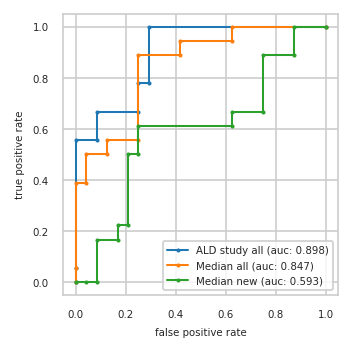

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       Median all       Median new      
             fpr   tpr        fpr   tpr        fpr   tpr
0          0.000 0.000      0.000 0.000      0.000 0.000
1          0.000 0.056      0.000 0.056      0.042 0.000
2          0.000 0.556      0.000 0.389      0.083 0.000
3          0.083 0.556      0.042 0.389      0.083 0.167
4          0.083 0.667      0.042 0.500      0.167 0.167
5          0.250 0.667      0.125 0.500      0.167 0.222
6          0.250 0.778      0.125 0.556      0.208 0.222
7          0.292 0.778      0.250 0.556      0.208 0.500
8          0.292 1.000      0.250 0.889      0.250 0.500
9          1.000 1.000      0.417 0.889      0.250 0.611
10           NaN   NaN      0.417 0.944      0.625 0.611
11           NaN   NaN      0.625 0.944      0.625 0.667
12           NaN   NaN      0.625 1.000      0.750 0.667
13           NaN   NaN      1.000 1.000      0.750 0.889
14           NaN   NaN        NaN   NaN      0.875 0.889
15           NaN   NaN        NaN   NaN      0.875 1.000
16           NaN   NaN        NaN   NaN      1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,Median all,Median new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,F5H265,B1AN99;P35030;P35030-2;P35030-3;P35030-4;P35030-5,P51688
2,A0A0A0MRJ7;P12259,P10636-2;P10636-6,Q8NFP4;Q8NFP4-2
3,P61981,P10643,A0A087WTT8;A0A0A0MQX5;O94779;O94779-2
4,P14174,P04075,Q504Y2
5,P04075,P14174,Q96GD0
6,P05160,P25189;P25189-2,A0A075B7B8
7,C9JF17;P05090,P61981,J3KSJ8;Q9UD71;Q9UD71-2
8,P00338;P00338-3,P00338;P00338-3,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_Median/prec_recall_curve.pdf


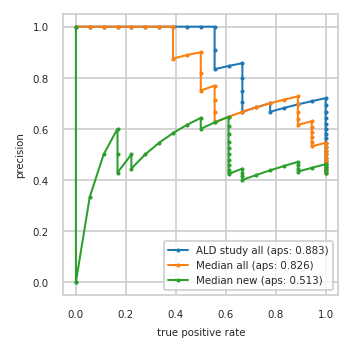

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       Median all       Median new      
       precision   tpr  precision   tpr  precision   tpr
0          0.429 1.000      0.429 1.000      0.429 1.000
1          0.439 1.000      0.439 1.000      0.439 1.000
2          0.450 1.000      0.450 1.000      0.450 1.000
3          0.462 1.000      0.462 1.000      0.462 1.000
4          0.474 1.000      0.474 1.000      0.447 0.944
5          0.486 1.000      0.486 1.000      0.432 0.889
6          0.500 1.000      0.500 1.000      0.444 0.889
7          0.514 1.000      0.514 1.000      0.457 0.889
8          0.529 1.000      0.529 1.000      0.471 0.889
9          0.545 1.000      0.545 1.000      0.455 0.833
10         0.562 1.000      0.531 0.944      0.438 0.778
11         0.581 1.000      0.548 0.944      0.419 0.722
12         0.600 1.000      0.567 0.944      0.400 0.667
13         0.621 1.000      0.586 0.944      0.414 0.667
14         0.643 1.000      0.607 0.944      0.429 0.667
15         0.667 1.000      0.630 0.944      0.444 0.667
16         0.692 1.000      0.615 0.889      0.423 0.611
17         0.720 1.000      0.640 0.889      0.440 0.611
18         0.708 0.944      0.667 0.889      0.458 0.611
19         0.696 0.889      0.696 0.889      0.478 0.611
20         0.682 0.833      0.727 0.889      0.500 0.611
21         0.667 0.778      0.714 0.833      0.524 0.611
22         0.700 0.778      0.700 0.778      0.550 0.611
23         0.684 0.722      0.684 0.722      0.579 0.611
24         0.667 0.667      0.667 0.667      0.611 0.611
25         0.706 0.667      0.647 0.611      0.647 0.611
26         0.750 0.667      0.625 0.556      0.625 0.556
27         0.800 0.667      0.667 0.556      0.600 0.500
28         0.857 0.667      0.714 0.556      0.643 0.500
29         0.846 0.611      0.769 0.556      0.615 0.444
30         0.833 0.556      0.750 0.500      0.583 0.389
31         0.909 0.556      0.818 0.500      0.545 0.333
32         1.000 0.556      0.900 0.500      0.500 0.278
33         1.000 0.500      0.889 0.444      0.444 0.222
34         1.000 0.444      0.875 0.389      0.500 0.222
35         1.000 0.389      1.000 0.389      0.429 0.167
36         1.000 0.333      1.000 0.333      0.500 0.167
37         1.000 0.278      1.000 0.278      0.600 0.167
38         1.000 0.222      1.000 0.222      0.500 0.111
39         1.000 0.167      1.000 0.167      0.333 0.056
40         1.000 0.111      1.000 0.111      0.000 0.000
41         1.000 0.056      1.000 0.056      0.000 0.000
42         1.000 0.000      1.000 0.000      1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_Median/prec_recall_curve_train.pdf


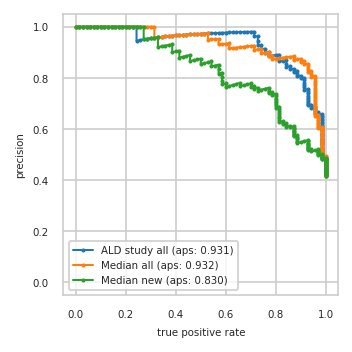

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_Median/auc_roc_curve_train.pdf


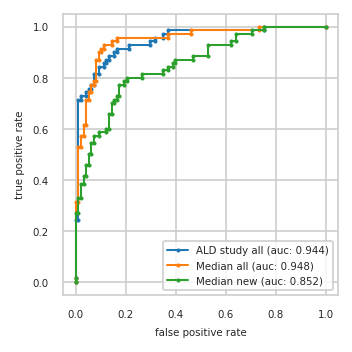

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_Median all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_Median/results_Median all.pkl'),
 'results_Median new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_Median/results_Median new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_Median/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_Median/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_Median/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_Median/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_Median/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_Median/auc_roc_curve_train.pdf')}